In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv
/kaggle/input/gdz-elektrik-datathon-2023/med.csv
/kaggle/input/gdz-elektrik-datathon-2023/train.csv


In [2]:
df = pd.read_csv("/kaggle/input/gdz-elektrik-datathon-2023/train.csv")
df.columns = ["tarih","enerji"]
df = df.set_index("tarih")
df.index = pd.to_datetime(df.index)

In [3]:
df.isna().sum()

enerji    0
dtype: int64

In [4]:
df

,enerji
tarih,
2018-01-01 00:00:00,1593.944216
2018-01-01 01:00:00,1513.933887
2018-01-01 02:00:00,1402.612637
2018-01-01 03:00:00,1278.527266
2018-01-01 04:00:00,1220.697701
...,...
2022-07-31 19:00:00,2492.489498
2022-07-31 20:00:00,2479.958245
2022-07-31 21:00:00,2485.016884


In [5]:
med = pd.read_csv("/kaggle/input/gdz-elektrik-datathon-2023/med.csv")

In [6]:
med.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tarih   30 non-null     object
dtypes: object(1)
memory usage: 368.0+ bytes


<AxesSubplot:title={'center':'Hourly Energy'}, xlabel='tarih'>

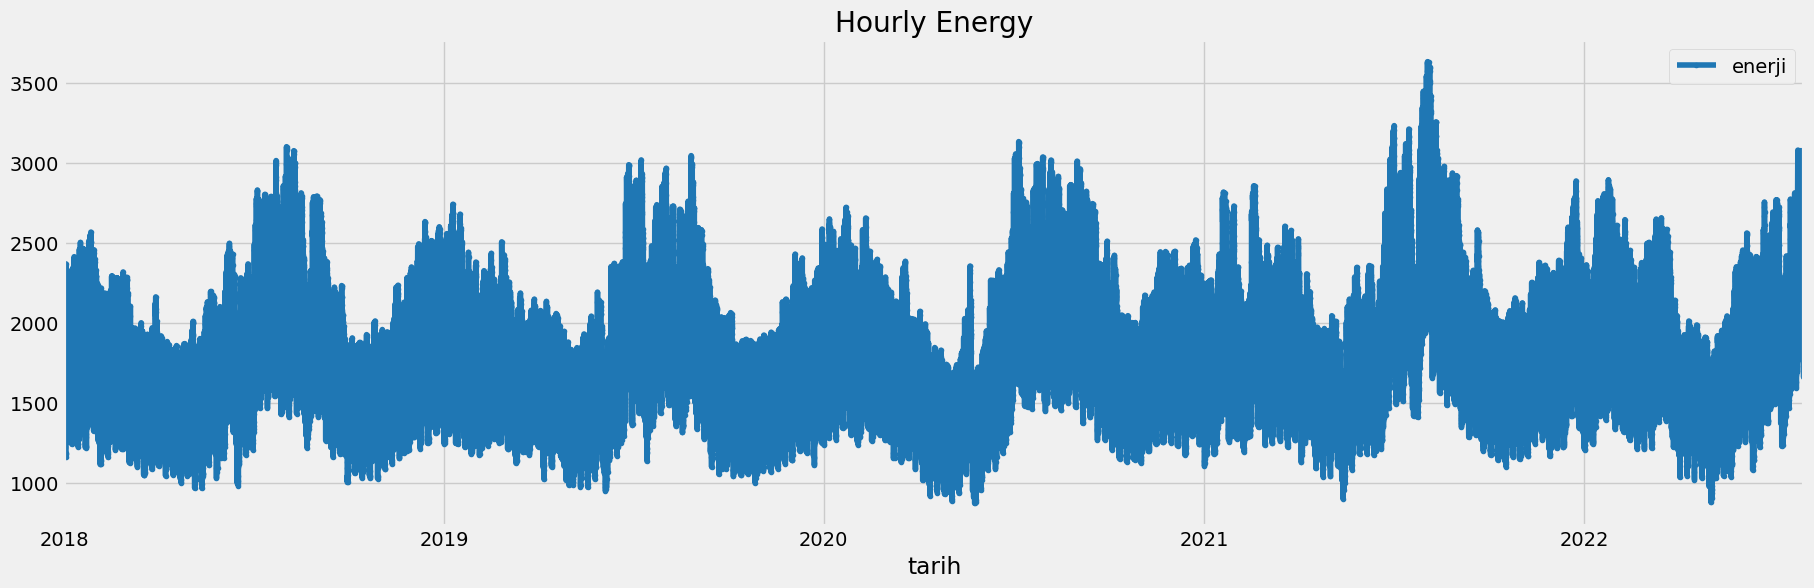

In [7]:
color_pal=sns.color_palette()
plt.style.use('fivethirtyeight')
df.plot(marker=".",figsize=(20,6),color=color_pal[0],title="Hourly Energy")

<AxesSubplot:>

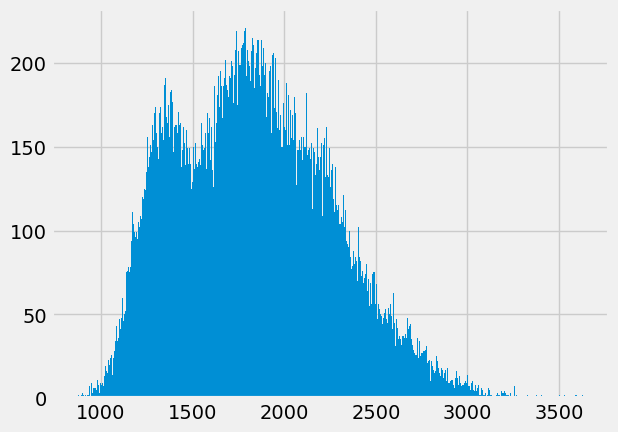

In [8]:
df["enerji"].hist(bins=500)

In [9]:
df.query("enerji>3300")

,enerji
tarih,
2021-07-29 15:00:00,3328.381240
2021-07-29 16:00:00,3345.864651
2021-07-30 14:00:00,3403.322968
2021-07-30 15:00:00,3447.503014
2021-07-30 16:00:00,3423.588785
2021-07-30 17:00:00,3337.434496
2021-08-02 12:00:00,3316.862995
2021-08-02 13:00:00,3442.557426
2021-08-02 14:00:00,3542.589166


In [10]:
from sklearn.model_selection import TimeSeriesSplit
tss= TimeSeriesSplit(n_splits=3,test_size=24*31*1,gap=24)
df = df.sort_index()

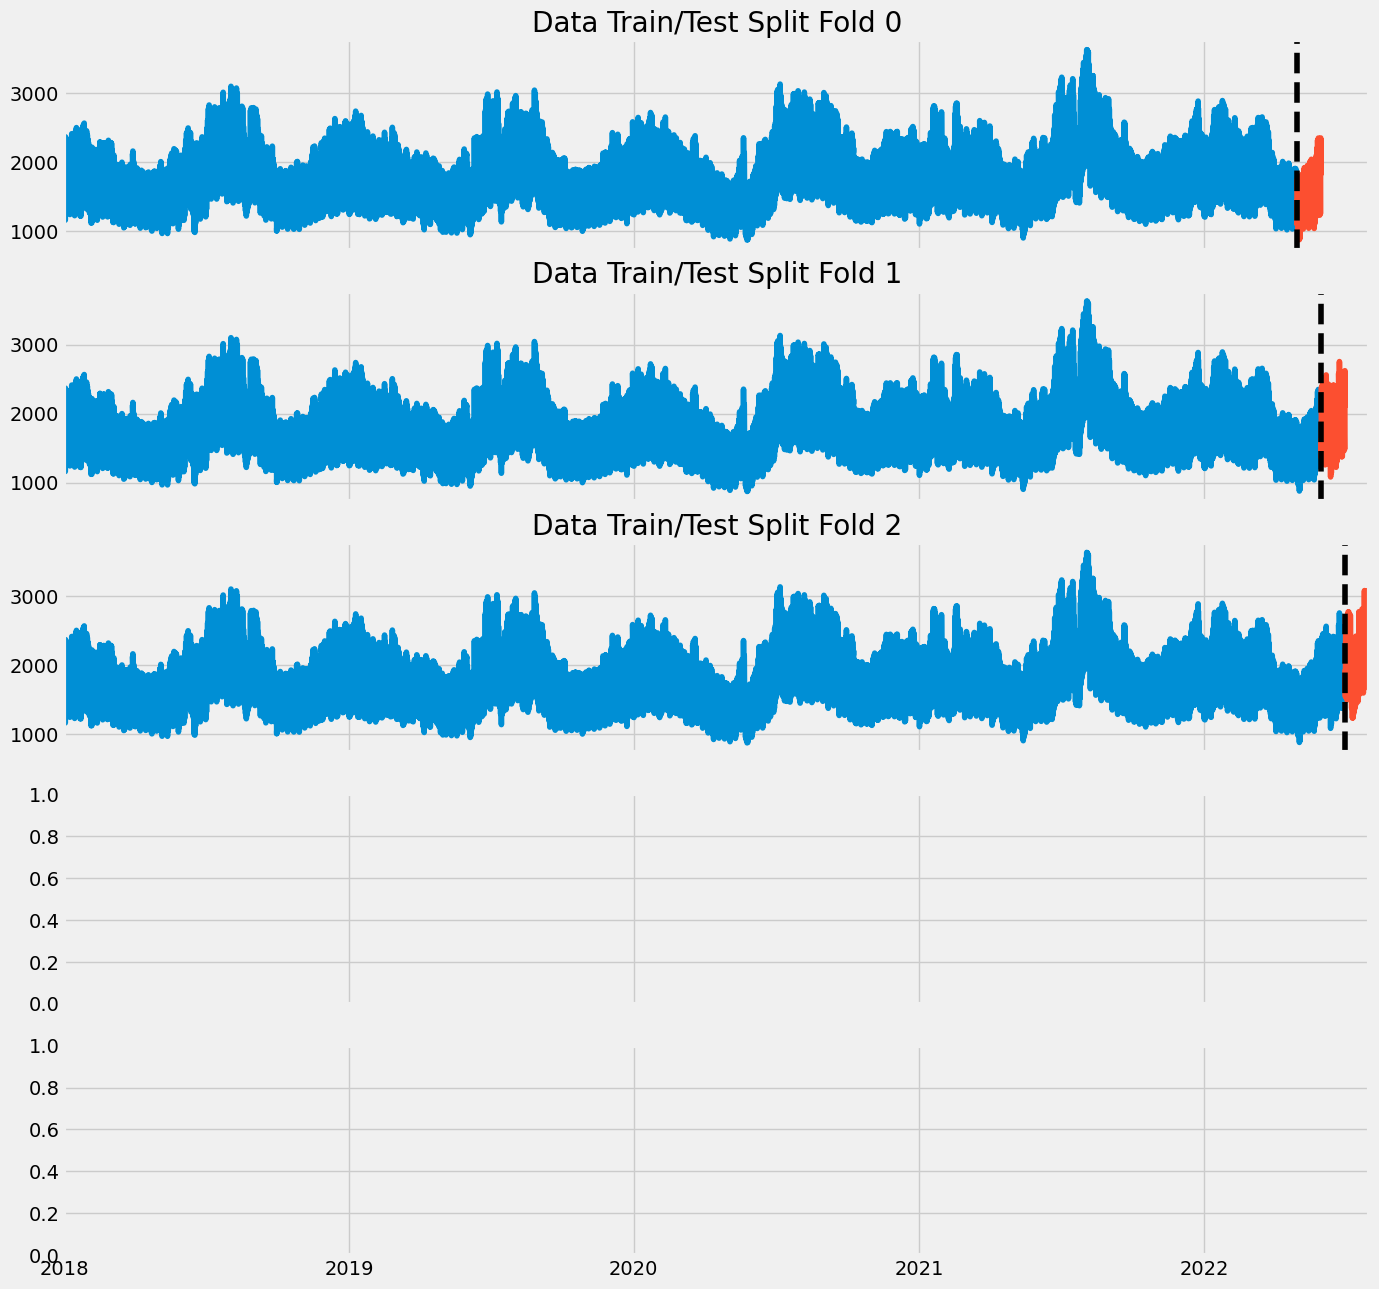

In [11]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['enerji'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['enerji'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [12]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    day = 60*60*24
    year = 365.2425*day
    month = day*30
    week = day*7
    hour = 60*60
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

 
    return df

df = create_features(df)

In [13]:
df

,enerji,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
tarih,,,,,,,,,
2018-01-01 00:00:00,1593.944216,0,0,1,1,2018,1,1,1
2018-01-01 01:00:00,1513.933887,1,0,1,1,2018,1,1,1
2018-01-01 02:00:00,1402.612637,2,0,1,1,2018,1,1,1
2018-01-01 03:00:00,1278.527266,3,0,1,1,2018,1,1,1
2018-01-01 04:00:00,1220.697701,4,0,1,1,2018,1,1,1
...,...,...,...,...,...,...,...,...,...
2022-07-31 19:00:00,2492.489498,19,6,3,7,2022,212,31,30
2022-07-31 20:00:00,2479.958245,20,6,3,7,2022,212,31,30
2022-07-31 21:00:00,2485.016884,21,6,3,7,2022,212,31,30


In [14]:
def add_lags(df):
    target_map = df['enerji'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)  
    return df

In [15]:
df = add_lags(df)

In [16]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*31, gap=24)
df = df.sort_index()

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'enerji'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor( n_jobs=-1, objective='reg:squarederror', booster='gbtree', max_depth=3, eta=0.1, n_estimators=500,
        reg_lambda=0
    )
    
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = mean_absolute_percentage_error(y_test, y_pred)
    scores.append(score)

[0]	validation_0-rmse:1699.89896	validation_1-rmse:1794.23290
[100]	validation_0-rmse:151.56274	validation_1-rmse:157.38006
[200]	validation_0-rmse:135.99409	validation_1-rmse:153.36522
[300]	validation_0-rmse:126.99499	validation_1-rmse:167.30634
[400]	validation_0-rmse:120.39181	validation_1-rmse:174.43004
[499]	validation_0-rmse:115.51964	validation_1-rmse:188.28370
[0]	validation_0-rmse:1701.79355	validation_1-rmse:1439.83421
[100]	validation_0-rmse:150.53556	validation_1-rmse:143.33993
[200]	validation_0-rmse:135.84930	validation_1-rmse:133.16977
[300]	validation_0-rmse:127.85134	validation_1-rmse:133.62493
[400]	validation_0-rmse:120.12658	validation_1-rmse:135.76724
[499]	validation_0-rmse:114.38718	validation_1-rmse:134.81959
[0]	validation_0-rmse:1697.46574	validation_1-rmse:1432.71747
[100]	validation_0-rmse:150.61169	validation_1-rmse:194.97040
[200]	validation_0-rmse:134.44855	validation_1-rmse:187.27511
[300]	validation_0-rmse:126.51460	validation_1-rmse:185.48970
[400]	va

In [17]:
mean_absolute_percentage_error(y_test,y_pred)

7.471398543359401

In [20]:
# Create future dataframe
future = pd.date_range('2022-08-01 00:00:00','2022-08-31 23:00:00', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
df_and_future

,enerji,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2018-01-01 00:00:00,1593.944216,0,0,1,1,2018,1,1,1,NaN,NaN,NaN,False
2018-01-01 01:00:00,1513.933887,1,0,1,1,2018,1,1,1,NaN,NaN,NaN,False
2018-01-01 02:00:00,1402.612637,2,0,1,1,2018,1,1,1,NaN,NaN,NaN,False
2018-01-01 03:00:00,1278.527266,3,0,1,1,2018,1,1,1,NaN,NaN,NaN,False
2018-01-01 04:00:00,1220.697701,4,0,1,1,2018,1,1,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 19:00:00,NaN,19,2,3,8,2022,243,31,35,2465.729820,2585.969806,2313.684111,True
2022-08-31 20:00:00,NaN,20,2,3,8,2022,243,31,35,2492.323783,2628.482996,2322.690733,True
2022-08-31 21:00:00,NaN,21,2,3,8,2022,243,31,35,2356.816997,2508.054810,2206.077681,True
2022-08-31 22:00:00,NaN,22,2,3,8,2022,243,31,35,2253.909837,2369.201184,2085.464487,True


In [21]:
future_w_features = df_and_future.query('isFuture').copy()

In [22]:
future_w_features.head()

,enerji,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2022-08-01 00:00:00,NaN,0,0,3,8,2022,213,1,31,2599.766650,1935.462260,1941.565596,True
2022-08-01 01:00:00,NaN,1,0,3,8,2022,213,1,31,2417.310610,1817.717466,1792.989152,True
2022-08-01 02:00:00,NaN,2,0,3,8,2022,213,1,31,2265.558033,1696.164752,1675.235546,True
2022-08-01 03:00:00,NaN,3,0,3,8,2022,213,1,31,2168.612720,1632.852579,1600.905424,True
2022-08-01 04:00:00,NaN,4,0,3,8,2022,213,1,31,2095.797068,1580.401184,1564.533322,True


In [23]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

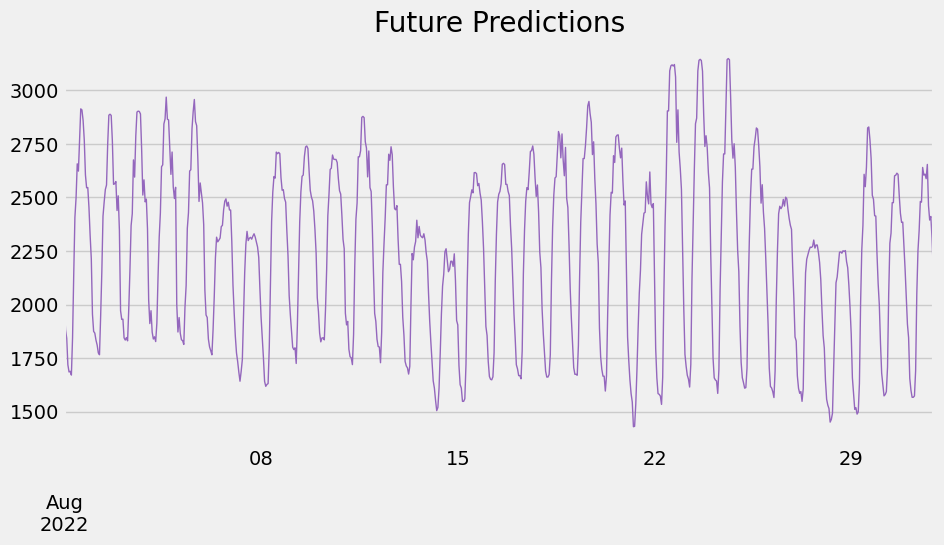

In [24]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [28]:
submission = future_w_features.reset_index()
submission=submission[["index","pred"]]
submission.columns = ['Tarih', 'Dağıtılan Enerji (MWh)']
submission.to_csv("xgboost.csv",index=False)
submission

,Tarih,Dağıtılan Enerji (MWh)
0,2022-08-01 00:00:00,1988.295288
1,2022-08-01 01:00:00,1882.502930
2,2022-08-01 02:00:00,1842.682251
3,2022-08-01 03:00:00,1718.790161
4,2022-08-01 04:00:00,1685.279297
...,...,...
739,2022-08-31 19:00:00,2394.333008
740,2022-08-31 20:00:00,2411.017334
741,2022-08-31 21:00:00,2310.258789
742,2022-08-31 22:00:00,2171.325684
